In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
.!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.applications import DenseNet121
from keras.applications import ResNet50V2
from keras.applications import InceptionResNetV2

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import gc
import random
init_notebook_mode(connected=True)
%matplotlib inline

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

## GLOBAL VARIABLES
dataset = "PU"
test_ratio = 0.2
windowSize = 3

def loadData(name):
    data_path = os.getcwd()
    if name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_tr.mat'))['PaviaUni_train']
        testlabels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels, testlabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX, pca


def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX


def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


def resizeX(X):
    new = []
    for sample in range (X.shape[0]):
        temp = np.zeros((224, 224, X.shape[3]))
        for layer in range (X.shape[3]):
            temp[:,:,layer] = np.resize(X[sample,:,:,layer], (224,224))
        new.append(temp)
    new = np.array(new)
    print("%d bytes" % (new.size * new.itemsize))
    return new

Using TensorFlow backend.


Using CUDA


In [2]:
X, y, ytest = loadData(dataset)
print("%d bytes" % (X.size * X.itemsize))
print("%d bytes" % (y.size * y.itemsize))
print("%d bytes" % (ytest.size * ytest.itemsize))
X.shape, y.shape, ytest.shape

42724400 bytes
207400 bytes
207400 bytes


((610, 340, 103), (610, 340), (610, 340))

In [3]:
K = 3
X,pca = applyPCA(X,numComponents=K)
print("%d bytes" % (X.size * X.itemsize))
X.shape

4977600 bytes


(610, 340, 3)

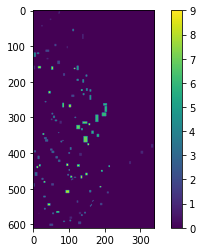

In [4]:
imgplot = plt.imshow(y)
plt.colorbar()

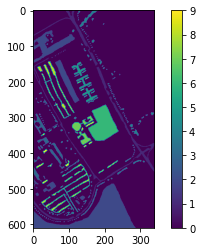

In [5]:
imgplot = plt.imshow(ytest)
plt.colorbar()

In [6]:
Xtest = X
X, y = createImageCubes(X, y, windowSize=windowSize)
print("%d bytes" % (X.size * X.itemsize))
print("%d bytes" % (Xtest.size * Xtest.itemsize))
print("%d bytes" % (y.size * y.itemsize))
X.shape, y.shape

846936 bytes
4977600 bytes
31368 bytes


((3921, 3, 3, 3), (3921,))

In [7]:
Xtrain = resizeX(X)
del X
Xtrain.shape

4721762304 bytes


(3921, 224, 224, 3)

In [8]:
#Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
ytrain = y
del y
Xtrain.shape, ytrain.shape

((3921, 224, 224, 3), (3921,))

In [9]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3921, 9)

In [10]:
model = keras.models.Sequential()
model_x = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
model.add(model_x)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(9, activation='softmax'))
for layer in model_x.layers[:]:
  layer.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               19661312  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 4617      
Total params: 74,265,321
Trainable params: 19,928,585
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [13]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=128, epochs=350, callbacks=callbacks_list)

Epoch 1/350
3921/3921 [==============================] - 74s 19ms/step - loss: 5.1592 - accuracy: 0.2028

Epoch 00001: accuracy improved from -inf to 0.20275, saving model to best-model.hdf5
Epoch 2/350
3921/3921 [==============================] - 54s 14ms/step - loss: 1.5736 - accuracy: 0.4583

Epoch 00002: accuracy improved from 0.20275 to 0.45830, saving model to best-model.hdf5
Epoch 3/350
3921/3921 [==============================] - 54s 14ms/step - loss: 1.3444 - accuracy: 0.5267

Epoch 00003: accuracy improved from 0.45830 to 0.52665, saving model to best-model.hdf5
Epoch 4/350
3921/3921 [==============================] - 54s 14ms/step - loss: 1.2572 - accuracy: 0.5537

Epoch 00004: accuracy improved from 0.52665 to 0.55369, saving model to best-model.hdf5
Epoch 5/350
3921/3921 [==============================] - 54s 14ms/step - loss: 1.1593 - accuracy: 0.5973

Epoch 00005: accuracy improved from 0.55369 to 0.59730, saving model to best-model.hdf5
Epoch 6/350
3921/3921 [==========

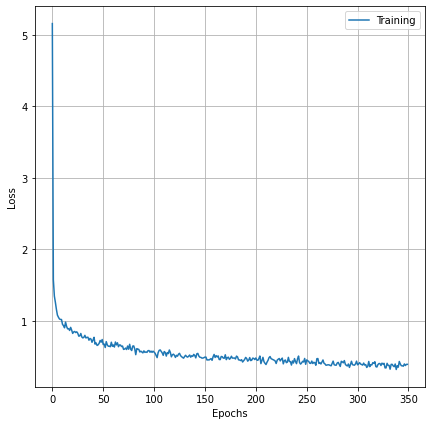

In [14]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig("loss_curve.pdf") 
plt.show()

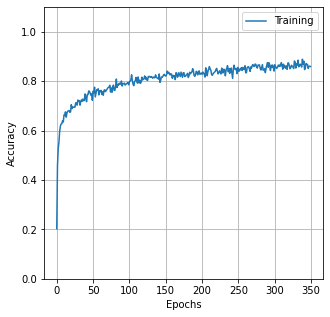

In [15]:
plt.figure(figsize=(5,5)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig("acc_curve.pdf") 
plt.show()

In [16]:
del Xtrain
Xtest, ytest = createImageCubes(Xtest, ytest, windowSize=windowSize)
Xtest.shape, ytest.shape

((42776, 3, 3, 3), (42776,))

In [17]:
random.seed(5)
idx = random.sample(range(len(Xtest)), 4000)
Xtest = Xtest[idx,:,:,:]
ytest = ytest[idx]
print("%d bytes" % (Xtest.size * Xtest.itemsize))
print("%d bytes" % (ytest.size * ytest.itemsize))

Xtest.shape, ytest.shape

864000 bytes
32000 bytes


((4000, 3, 3, 3), (4000,))

In [18]:
Xtest = resizeX(Xtest)
ytest = np_utils.to_categorical(ytest)
Xtest.shape, ytest.shape

4816896000 bytes


((4000, 224, 224, 3), (4000, 9))

In [ ]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [20]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.84      0.64      0.73       621
           1       0.87      0.62      0.72      1745
           2       0.29      0.48      0.36       195
           3       0.45      0.94      0.61       318
           4       0.96      0.86      0.91       118
           5       0.41      0.49      0.45       463
           6       0.51      0.69      0.58       124
           7       0.58      0.65      0.61       337
           8       0.90      0.96      0.93        79

    accuracy                           0.65      4000
   macro avg       0.64      0.70      0.66      4000
weighted avg       0.72      0.65      0.66      4000



In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc


def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [22]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

4000/4000 [==============================] - 74s 18ms/step


In [ ]:
del Xtest